In [1]:
import numpy as np
from shutil import copyfile
from collections import namedtuple, deque
import random
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

from IPython.display import display, clear_output

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
class Environment():
    
    def __init__(self,path):
        self.env = UnityEnvironment(file_name=path);
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.action_size = self.brain.vector_action_space_size
        info = self.env.reset(train_mode=True)[self.brain_name]
        self.state_size = len(info.vector_observations[0])
        self.num_agents = len(info.agents)
        self.print_info(info.vector_observations)
        
    def close(self):
        self.env.close()
    
    def reset(self,train=True):
        info = self.env.reset(train_mode=train)[self.brain_name]
        return info.vector_observations
    
    def step(self,action):
        info = self.env.step(action)[self.brain_name]
        state = info.vector_observations
        reward = info.rewards
        done = info.local_done
        return state, reward, done, info
    
    def print_info(self, state=None):
        print('Num agents: \t', self.num_agents)
        print('State size: \t', self.state_size)
        print('Action size:\t', self.action_size)
        if state is not None:
            print('Raw State shape:\t', state.shape)
            print('Raw State content:\n', state)

In [5]:
env = Environment("Tennis.app") 
# Place the Tennis.app file in the directory and pass "Tennis.app"

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Num agents: 	 2
State size: 	 24
Action size:	 2
Raw State shape:	 (2, 24)
Raw State content:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.65278625 -1.5
  -0.          0.          6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4669857  -1.5
   0.          0.         -6.83172083  6.          0.          0.        ]]


In [6]:
def hidden_init(layer):
    fanin = layer.weight.data.size()[0]
    limit = (1.0/ np.sqrt(fanin))
    return (-limit, limit)

In [7]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """ 
        PARAMETERS: 
            state_size (int): Dimension of a state
            action_size (int): Dimension of an action
            seed (int): Rand seed
            fc1_units (int): No. of nodes in 1st hidden layer
            fc2_units (int): No. of nodes in 2nd hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()


    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


In [8]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """ 
        PARAMETERS: 
            state_size (int): Dimension of a state
            action_size (int): Dimension of an action
            seed (int): Rand seed
            fcs1_units (int): No. of nodes in the first hidden layer
            fc2_units (int): No. of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x = F.relu(self.fcs1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
class ReplayBuffer:

    def __init__(self, buffer_size, batch_size, seed):
        """
        PARAMETERS:
            buffer_size(int): Maximum buffer size
            batch_size(int): Training batch size 
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):

        exps = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in exps if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in exps if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in exps if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in exps if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
class ReplayBufferPrioritized:
    def __init__(self, batch_size, buffer_size, seed, min_delta=1e-5):
        self.seed = random.seed(seed)
        
        self.batch_size = batch_size
        self.min_delta = min_delta
        
        self.buffer = deque(maxlen=buffer_size)
        self.deltas = deque(maxlen=buffer_size)
        
        self.exp_template = namedtuple("exp", field_names=["state","action","reward","new_state","done"])
    
    def add(self, state, action, reward, new_state, done):
        exp = self.exp_template(state, action, reward, new_state, int(done))
        self.buffer.append(exp)
        self.deltas.append( max(self.deltas) if len(self.deltas) > 0 else self.min_delta )
    
    def sample(self,priority=0.5):
        deltas = np.array(self.deltas)
        probs = deltas**priority / np.sum(deltas**priority)
        
        exp_batch_idx = np.random.choice(np.arange(len(self.buffer)), size=self.batch_size, p=probs, replace=False)
         
        states = torch.from_numpy(np.vstack([self.buffer[idx].state for idx in exp_batch_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.buffer[idx].action for idx in exp_batch_idx])).float().to(device)
        rewards = torch.from_numpy(np.vstack([self.buffer[idx].reward for idx in exp_batch_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.buffer[idx].new_state for idx in exp_batch_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.buffer[idx].done for idx in exp_batch_idx])).float().to(device)
        probabilities = torch.from_numpy(np.vstack([probs[idx] for idx in exp_batch_idx])).float().to(device)
        
        return states, actions, rewards, new_states, dones, probabilities, exp_batch_idx
    
    def update_deltas(self,idxs,deltas):
        for i,idx in enumerate(idxs):
            self.deltas[idx] = deltas[i] + self.min_delta
    
    def __len__(self):
        return len(self.buffer)

In [11]:
class OUNoise: #Ornstein-Uhlenbeck process

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        rnd = np.random.standard_normal(self.size)

        dx = self.theta * (self.mu - x) + self.sigma * rnd
        self.state = x + dx
        return self.state

In [12]:
class Agent():
    
    def __init__(self, num_agents, state_size, action_size, buffer_size, batch_size, learn_every, update_every, random_seed, use_pre):
        """
        PARAMETERS:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.update_every = update_every
        self.learn_every = learn_every
        self.seed = random.seed(random_seed)
        self.use_pre = use_pre
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = lr_actor)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = lr_critic, weight_decay = weight_decay)
        self.noise = OUNoise((num_agents,action_size), random_seed)
        if self.use_pre:
            self.memory = ReplayBufferPrioritized(self.buffer_size, self.batch_size, random_seed)
        else:
            self.memory = ReplayBuffer(self.buffer_size, self.batch_size, random_seed)
        
        print(self.actor_local)

        print(self.critic_local)

    def step(self, state, action, reward, next_state, done, priority=0.):
        for i in range(self.num_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])
        
        self.i_step = self.i_step + 1            
        to_learn = (self.i_step % self.learn_every ) == 0
        to_update = ( self.i_step % self.update_every ) == 0
        
        if len(self.memory) > self.batch_size:
            if to_learn:
                exps = None
                if self.use_pre:
                    exps = self.memory.sample(priority)
                else:
                    exps = self.memory.sample()
                self.learn(exps, gamma)
        
            if to_update:
                self.soft_update(self.critic_local, self.critic_target, tau)
                self.soft_update(self.actor_local, self.actor_target, tau) 

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.i_step=0

    def learn(self, exps, gamma):
        if self.use_pre:
            states, actions, rewards, next_states, dones, probs, batch_idx = exps
        else:
            states, actions, rewards, next_states, dones = exps
            
        actions_next = self.actor_target(next_states)
        Qtargs_next = self.critic_target(next_states, actions_next)
        Qtargs = rewards + (gamma * Qtargs_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Qtargs)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()    
        
        if self.use_pre:
            Q_error = Q_expected - Qtargs
            nd_ = torch.abs(td_error.detach().squeeze(1)).numpy()
            self.memory.update_deltas(batch_idx,nd_)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
use_pre = False
PRE_PRIORITY_START = 0.5
PRE_PRIORITY_END = 0.0
PRE_PRIORITY_DECAY = 0.991

batch_size = 128
buffer_size = int(1e+5)
gamma = 0.99
tau = 1e-3
weight_decay = 0
lr_actor = 1e-4
lr_critic = 1e-4
update_step = 1
learn_step  = 1
rand_seed = 0

num_episodes = 9000

session = str(int(time.time()))

agent_config = {
    'num_agents':env.num_agents,
    'state_size':env.state_size,
    'action_size':env.action_size,
    'buffer_size':buffer_size,
    'batch_size':batch_size,
    'learn_every':learn_step,
    'update_every':update_step,
    'random_seed':rand_seed,
    'use_pre':use_pre
    
}

agent = Agent(**agent_config)

def DDPG(n_episodes=num_episodes):
    priority = PRE_PRIORITY_START
    print_every=100
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = 0
    for i_episode in range(1, n_episodes+1):
        states = env.reset()
        agent.reset()
        score = np.zeros(env.num_agents)
        priority = max(priority * PRE_PRIORITY_DECAY, PRE_PRIORITY_END)
        while True:
            actions = agent.act(states)
            next_states, rewards, dones, _ = env.step(actions)
            agent.step(states, actions, rewards, next_states, dones, priority)
            score = score + rewards
            states = next_states
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)
        avgscore_ep = np.mean(score)
        avgscore_100 = np.mean(scores_deque)
        print('\rEpisode {}/{}\tScore: {:.2f} \tAvgScore: {:.2f}'.format(i_episode, n_episodes, avgscore_ep, avgscore_100 ), end="")
        
        if i_episode % print_every == 0:
            print('')
        
        if avgscore_100 >= 0.5:
            print(f"\n***Solved! Episodes taken: {i_episode:d} AvgScore: {avgscore_100:.3f}***")
            if avgscore_100 > max_score:
                max_score = avgscore_100
                #saving weights of networks
                file_tpl = 'savedmodels/checkpoint_{}_{}_episode{}_score{:.3f}.pth'
                file_tpl_best = 'savedmodels/checkpoint_{}_{}_best.pth'
                fileactor = file_tpl.format(session,'actor', i_episode, avgscore_100)
                filecritic = file_tpl.format(session,'critic', i_episode, avgscore_100)
                torch.save(agent.actor_local.state_dict(), fileactor)
                torch.save(agent.critic_local.state_dict(), filecritic)
                copyfile(fileactor, file_tpl_best.format(session,'actor'))
                copyfile(filecritic, file_tpl_best.format(session,'critic')) 
            
                
    return scores


Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


## Training

In [15]:
scores = DDPG()

Episode 100/9000	Score: -0.00 	AvgScore: 0.01
Episode 200/9000	Score: -0.00 	AvgScore: 0.01
Episode 300/9000	Score: -0.00 	AvgScore: 0.02
Episode 400/9000	Score: -0.00 	AvgScore: 0.01
Episode 500/9000	Score: -0.00 	AvgScore: 0.01
Episode 600/9000	Score: -0.00 	AvgScore: 0.01
Episode 700/9000	Score: 0.05 	AvgScore: 0.011
Episode 800/9000	Score: -0.00 	AvgScore: 0.02
Episode 900/9000	Score: 0.05 	AvgScore: 0.022
Episode 1000/9000	Score: 0.05 	AvgScore: 0.03
Episode 1100/9000	Score: -0.00 	AvgScore: 0.03
Episode 1200/9000	Score: -0.00 	AvgScore: 0.03
Episode 1300/9000	Score: 0.05 	AvgScore: 0.044
Episode 1400/9000	Score: 0.05 	AvgScore: 0.044
Episode 1500/9000	Score: 0.05 	AvgScore: 0.065
Episode 1600/9000	Score: 0.05 	AvgScore: 0.076
Episode 1700/9000	Score: 0.05 	AvgScore: 0.100
Episode 1800/9000	Score: 0.20 	AvgScore: 0.187
Episode 1900/9000	Score: 0.10 	AvgScore: 0.200
Episode 2000/9000	Score: 0.15 	AvgScore: 0.230
Episode 2087/9000	Score: 1.35 	AvgScore: 0.507
***Solved! Episodes tak

Episode 2172/9000	Score: 0.40 	AvgScore: 0.57
***Solved! Episodes taken: 2172 AvgScore: 0.571***
Episode 2173/9000	Score: 1.55 	AvgScore: 0.59
***Solved! Episodes taken: 2173 AvgScore: 0.585***
Episode 2174/9000	Score: 0.20 	AvgScore: 0.57
***Solved! Episodes taken: 2174 AvgScore: 0.573***
Episode 2175/9000	Score: 0.54 	AvgScore: 0.57
***Solved! Episodes taken: 2175 AvgScore: 0.574***
Episode 2176/9000	Score: -0.00 	AvgScore: 0.56
***Solved! Episodes taken: 2176 AvgScore: 0.560***
Episode 2177/9000	Score: 0.05 	AvgScore: 0.55
***Solved! Episodes taken: 2177 AvgScore: 0.547***
Episode 2178/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 2178 AvgScore: 0.530***
Episode 2179/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 2179 AvgScore: 0.526***
Episode 2180/9000	Score: 1.05 	AvgScore: 0.53
***Solved! Episodes taken: 2180 AvgScore: 0.534***
Episode 2181/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 2181 AvgScore: 0.531***
Episode 2182/9000	Score: -

Episode 2470/9000	Score: 1.30 	AvgScore: 0.77
***Solved! Episodes taken: 2470 AvgScore: 0.768***
Episode 2471/9000	Score: 0.60 	AvgScore: 0.77
***Solved! Episodes taken: 2471 AvgScore: 0.765***
Episode 2472/9000	Score: 0.20 	AvgScore: 0.77
***Solved! Episodes taken: 2472 AvgScore: 0.766***
Episode 2473/9000	Score: 1.35 	AvgScore: 0.77
***Solved! Episodes taken: 2473 AvgScore: 0.774***
Episode 2474/9000	Score: 2.55 	AvgScore: 0.80
***Solved! Episodes taken: 2474 AvgScore: 0.799***
Episode 2475/9000	Score: 1.15 	AvgScore: 0.81
***Solved! Episodes taken: 2475 AvgScore: 0.809***
Episode 2476/9000	Score: 0.30 	AvgScore: 0.80
***Solved! Episodes taken: 2476 AvgScore: 0.804***
Episode 2477/9000	Score: 1.95 	AvgScore: 0.82
***Solved! Episodes taken: 2477 AvgScore: 0.822***
Episode 2478/9000	Score: 1.85 	AvgScore: 0.84
***Solved! Episodes taken: 2478 AvgScore: 0.838***
Episode 2479/9000	Score: 0.75 	AvgScore: 0.83
***Solved! Episodes taken: 2479 AvgScore: 0.833***
Episode 2480/9000	Score: 1.60 

Episode 2555/9000	Score: 0.15 	AvgScore: 0.68
***Solved! Episodes taken: 2555 AvgScore: 0.677***
Episode 2556/9000	Score: 0.70 	AvgScore: 0.67
***Solved! Episodes taken: 2556 AvgScore: 0.666***
Episode 2557/9000	Score: 0.75 	AvgScore: 0.66
***Solved! Episodes taken: 2557 AvgScore: 0.663***
Episode 2558/9000	Score: 1.05 	AvgScore: 0.66
***Solved! Episodes taken: 2558 AvgScore: 0.661***
Episode 2559/9000	Score: 0.50 	AvgScore: 0.66
***Solved! Episodes taken: 2559 AvgScore: 0.663***
Episode 2560/9000	Score: 1.05 	AvgScore: 0.67
***Solved! Episodes taken: 2560 AvgScore: 0.665***
Episode 2561/9000	Score: 0.15 	AvgScore: 0.66
***Solved! Episodes taken: 2561 AvgScore: 0.660***
Episode 2562/9000	Score: 0.45 	AvgScore: 0.66
***Solved! Episodes taken: 2562 AvgScore: 0.656***
Episode 2563/9000	Score: 0.15 	AvgScore: 0.66
***Solved! Episodes taken: 2563 AvgScore: 0.657***
Episode 2564/9000	Score: 0.55 	AvgScore: 0.66
***Solved! Episodes taken: 2564 AvgScore: 0.660***
Episode 2565/9000	Score: 0.25 

Episode 6687/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 6687 AvgScore: 0.526***
Episode 6688/9000	Score: 1.20 	AvgScore: 0.54
***Solved! Episodes taken: 6688 AvgScore: 0.537***
Episode 6689/9000	Score: 0.40 	AvgScore: 0.52
***Solved! Episodes taken: 6689 AvgScore: 0.515***
Episode 6690/9000	Score: 0.45 	AvgScore: 0.52
***Solved! Episodes taken: 6690 AvgScore: 0.518***
Episode 6691/9000	Score: -0.00 	AvgScore: 0.51
***Solved! Episodes taken: 6691 AvgScore: 0.512***
Episode 6692/9000	Score: 0.95 	AvgScore: 0.52
***Solved! Episodes taken: 6692 AvgScore: 0.518***
Episode 6693/9000	Score: 0.55 	AvgScore: 0.52
***Solved! Episodes taken: 6693 AvgScore: 0.523***
Episode 6694/9000	Score: 0.20 	AvgScore: 0.52
***Solved! Episodes taken: 6694 AvgScore: 0.523***
Episode 6695/9000	Score: 0.10 	AvgScore: 0.52
***Solved! Episodes taken: 6695 AvgScore: 0.519***
Episode 6696/9000	Score: 0.70 	AvgScore: 0.51
***Solved! Episodes taken: 6696 AvgScore: 0.514***
Episode 6697/9000	Score: -0.

Episode 7226/9000	Score: 0.70 	AvgScore: 0.53
***Solved! Episodes taken: 7226 AvgScore: 0.532***
Episode 7227/9000	Score: 0.20 	AvgScore: 0.53
***Solved! Episodes taken: 7227 AvgScore: 0.531***
Episode 7228/9000	Score: 0.65 	AvgScore: 0.53
***Solved! Episodes taken: 7228 AvgScore: 0.526***
Episode 7229/9000	Score: 1.35 	AvgScore: 0.54
***Solved! Episodes taken: 7229 AvgScore: 0.539***
Episode 7230/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 7230 AvgScore: 0.533***
Episode 7231/9000	Score: 0.50 	AvgScore: 0.54
***Solved! Episodes taken: 7231 AvgScore: 0.538***
Episode 7232/9000	Score: 1.25 	AvgScore: 0.55
***Solved! Episodes taken: 7232 AvgScore: 0.550***
Episode 7233/9000	Score: 0.95 	AvgScore: 0.56
***Solved! Episodes taken: 7233 AvgScore: 0.557***
Episode 7234/9000	Score: 0.60 	AvgScore: 0.56
***Solved! Episodes taken: 7234 AvgScore: 0.556***
Episode 7235/9000	Score: 1.40 	AvgScore: 0.57
***Solved! Episodes taken: 7235 AvgScore: 0.569***
Episode 7236/9000	Score: 1.05

Episode 7383/9000	Score: 0.60 	AvgScore: 0.54
***Solved! Episodes taken: 7383 AvgScore: 0.536***
Episode 7384/9000	Score: 0.25 	AvgScore: 0.53
***Solved! Episodes taken: 7384 AvgScore: 0.528***
Episode 7385/9000	Score: 1.15 	AvgScore: 0.54
***Solved! Episodes taken: 7385 AvgScore: 0.539***
Episode 7386/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 7386 AvgScore: 0.539***
Episode 7387/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 7387 AvgScore: 0.539***
Episode 7388/9000	Score: 0.30 	AvgScore: 0.54
***Solved! Episodes taken: 7388 AvgScore: 0.542***
Episode 7389/9000	Score: 0.30 	AvgScore: 0.54
***Solved! Episodes taken: 7389 AvgScore: 0.543***
Episode 7390/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 7390 AvgScore: 0.542***
Episode 7391/9000	Score: 0.85 	AvgScore: 0.55
***Solved! Episodes taken: 7391 AvgScore: 0.546***
Episode 7392/9000	Score: 1.05 	AvgScore: 0.56
***Solved! Episodes taken: 7392 AvgScore: 0.557***
Episode 7393/9000	Score: 0.

Episode 7600/9000	Score: 1.10 	AvgScore: 0.51

***Solved! Episodes taken: 7600 AvgScore: 0.509***
Episode 7601/9000	Score: 0.25 	AvgScore: 0.51
***Solved! Episodes taken: 7601 AvgScore: 0.510***
Episode 7602/9000	Score: -0.00 	AvgScore: 0.51
***Solved! Episodes taken: 7602 AvgScore: 0.509***
Episode 7603/9000	Score: 0.10 	AvgScore: 0.50
***Solved! Episodes taken: 7603 AvgScore: 0.504***
Episode 7604/9000	Score: 0.25 	AvgScore: 0.51
***Solved! Episodes taken: 7604 AvgScore: 0.505***
Episode 7606/9000	Score: 2.30 	AvgScore: 0.52
***Solved! Episodes taken: 7606 AvgScore: 0.517***
Episode 7607/9000	Score: 0.80 	AvgScore: 0.52
***Solved! Episodes taken: 7607 AvgScore: 0.522***
Episode 7608/9000	Score: -0.00 	AvgScore: 0.52
***Solved! Episodes taken: 7608 AvgScore: 0.516***
Episode 7609/9000	Score: 0.10 	AvgScore: 0.51
***Solved! Episodes taken: 7609 AvgScore: 0.511***
Episode 7610/9000	Score: -0.00 	AvgScore: 0.51
***Solved! Episodes taken: 7610 AvgScore: 0.506***
Episode 7611/9000	Score: 0

Episode 7688/9000	Score: 0.90 	AvgScore: 0.53
***Solved! Episodes taken: 7688 AvgScore: 0.529***
Episode 7689/9000	Score: 1.00 	AvgScore: 0.54
***Solved! Episodes taken: 7689 AvgScore: 0.539***
Episode 7690/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 7690 AvgScore: 0.526***
Episode 7691/9000	Score: -0.00 	AvgScore: 0.53
***Solved! Episodes taken: 7691 AvgScore: 0.526***
Episode 7692/9000	Score: -0.00 	AvgScore: 0.52
***Solved! Episodes taken: 7692 AvgScore: 0.521***
Episode 7693/9000	Score: 0.30 	AvgScore: 0.52
***Solved! Episodes taken: 7693 AvgScore: 0.524***
Episode 7694/9000	Score: 1.15 	AvgScore: 0.53
***Solved! Episodes taken: 7694 AvgScore: 0.535***
Episode 7695/9000	Score: 0.10 	AvgScore: 0.53
***Solved! Episodes taken: 7695 AvgScore: 0.531***
Episode 7696/9000	Score: 2.05 	AvgScore: 0.55
***Solved! Episodes taken: 7696 AvgScore: 0.552***
Episode 7697/9000	Score: 0.80 	AvgScore: 0.55
***Solved! Episodes taken: 7697 AvgScore: 0.553***
Episode 7698/9000	Score: -0

Episode 8002/9000	Score: -0.00 	AvgScore: 0.55
***Solved! Episodes taken: 8002 AvgScore: 0.546***
Episode 8003/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 8003 AvgScore: 0.545***
Episode 8004/9000	Score: 0.30 	AvgScore: 0.54
***Solved! Episodes taken: 8004 AvgScore: 0.544***
Episode 8005/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 8005 AvgScore: 0.541***
Episode 8006/9000	Score: 0.75 	AvgScore: 0.55
***Solved! Episodes taken: 8006 AvgScore: 0.549***
Episode 8007/9000	Score: 0.55 	AvgScore: 0.55
***Solved! Episodes taken: 8007 AvgScore: 0.553***
Episode 8008/9000	Score: 0.35 	AvgScore: 0.55
***Solved! Episodes taken: 8008 AvgScore: 0.546***
Episode 8009/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 8009 AvgScore: 0.543***
Episode 8010/9000	Score: -0.00 	AvgScore: 0.54
***Solved! Episodes taken: 8010 AvgScore: 0.542***
Episode 8011/9000	Score: 0.05 	AvgScore: 0.54
***Solved! Episodes taken: 8011 AvgScore: 0.538***
Episode 8012/9000	Score: 

Episode 8429/9000	Score: 0.20 	AvgScore: 0.61
***Solved! Episodes taken: 8429 AvgScore: 0.610***
Episode 8430/9000	Score: 0.25 	AvgScore: 0.61
***Solved! Episodes taken: 8430 AvgScore: 0.610***
Episode 8431/9000	Score: 0.30 	AvgScore: 0.61
***Solved! Episodes taken: 8431 AvgScore: 0.608***
Episode 8432/9000	Score: 0.25 	AvgScore: 0.61
***Solved! Episodes taken: 8432 AvgScore: 0.609***
Episode 8433/9000	Score: 0.10 	AvgScore: 0.58
***Solved! Episodes taken: 8433 AvgScore: 0.584***
Episode 8434/9000	Score: 0.10 	AvgScore: 0.57
***Solved! Episodes taken: 8434 AvgScore: 0.567***
Episode 8435/9000	Score: -0.00 	AvgScore: 0.57
***Solved! Episodes taken: 8435 AvgScore: 0.567***
Episode 8436/9000	Score: 0.10 	AvgScore: 0.56
***Solved! Episodes taken: 8436 AvgScore: 0.557***
Episode 8437/9000	Score: 0.40 	AvgScore: 0.55
***Solved! Episodes taken: 8437 AvgScore: 0.548***
Episode 8438/9000	Score: 0.75 	AvgScore: 0.56
***Solved! Episodes taken: 8438 AvgScore: 0.556***
Episode 8439/9000	Score: -0.0

## Performance

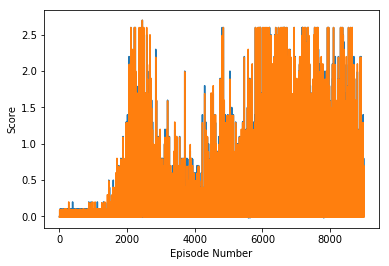

In [17]:
fig = plt.figure()
perf = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode Number')
plt.rcParams["figure.figsize"] = [18.0, 12.0]
plt.show()

In [1]:
!ls savedmodels

checkpoint_1545538436_actor_best.pth
checkpoint_1545538436_actor_episode2087_score0.503.pth
checkpoint_1545538436_actor_episode2098_score0.512.pth
checkpoint_1545538436_actor_episode2099_score0.519.pth
checkpoint_1545538436_actor_episode2100_score0.520.pth
checkpoint_1545538436_actor_episode2101_score0.526.pth
checkpoint_1545538436_actor_episode2103_score0.527.pth
checkpoint_1545538436_actor_episode2104_score0.532.pth
checkpoint_1545538436_actor_episode2107_score0.545.pth
checkpoint_1545538436_actor_episode2108_score0.556.pth
checkpoint_1545538436_actor_episode2109_score0.574.pth
checkpoint_1545538436_actor_episode2110_score0.575.pth
checkpoint_1545538436_actor_episode2111_score0.578.pth
checkpoint_1545538436_actor_episode2112_score0.580.pth
checkpoint_1545538436_actor_episode2113_score0.605.pth
checkpoint_1545538436_actor_episode2133_score0.607.pth
checkpoint_1545538436_actor_episode2135_score0.614.pth
checkpoint_1545538436_actor_episode2136_score0.619.pth
checkpoint_1545538436_actor_

In [18]:
session_name = '1545538436'
file_tpl_best = 'savedmodels/checkpoint_{}_{}_best.pth'

checkpoint_actor = file_tpl_best.format(session_name,'actor')
checkpoint_critic = file_tpl_best.format(session_name,'critic')

# torch.load(file, map_location='cpu')
agent.actor_local.load_state_dict(torch.load(checkpoint_actor, map_location='cpu'))
agent.critic_local.load_state_dict(torch.load(checkpoint_critic, map_location='cpu'))
        
state = env.reset(train=False)     
agent.reset()
scores = np.zeros(env.num_agents)                          
while True:
    action = agent.act(state, add_noise=False)                 
    next_state, reward, done, _ = env.step(action)
    scores += reward                         
    state = next_state                              
    if np.any(done):                              
        
print('Total score:',np.mean(scores))

Total score: 2.600000038743019
